In [4]:
import torch as th
print(th.__version__) # should be greater or equal to 1.0
import torch.nn as nn

import os

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 

import gzip

%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'

1.7.1


# Load the dataset

Select the directory :

In [5]:
#os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\')

Load the dataset :

In [9]:
fp = gzip.open('linear_dataset.pickle.gz','rb')
Ztrain,Zvalid,Ytrain,Yvalid = pickle.load(fp)

# 1. Classifieur linéaire


- **a = $w$.X + $w_{0}$** : un poids est associé à chaque pixel
- P(C=1|**X**) = $\sigma(a)$
- Descente de gradient pour optimiser ($w,w_{0}$)

In [10]:
def train(model, epochs=60,verbose=False):
    # The verbose allows you to skip printed information per epoch.
    # The function will only print the best accuracy on the validation
    # and plot the learning curves. 
    
    ### Mini-batching and shuffle 
    Ntrain = Ztrain.shape[0]
    Nvalid = Zvalid.shape[0]
    print(Ntrain,Nvalid)
    idx = np.arange(Ntrain)
    batch_size = 150 
    nbatch = int(Ntrain/batch_size)
    print(batch_size, nbatch)


    train_losses,valid_losses, valid_accuracies=[],[],[]


    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images 
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Ztrain[ids]
            labels = Ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0        
        with th.no_grad(): # On est plus entrain d'apprendre 
            model.eval()
            images = Zvalid
            labels = Yvalid
            logprobs=model(images)
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)
            accuracy=(top_class.T == labels).sum().float()
        model.train()
        train_losses.append(running_loss/nbatch)
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        '''
        print("Epoch: {}\t".format(e+1),
                  "train Loss: {:.5f}.. ".format(train_losses[-1]),
                  "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
                  "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
        '''
    print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
          , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )
    
    plt.figure(figsize = (10, 2))
    ax= plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Train losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 2)
    plt.plot(valid_losses)
    plt.title('Valid losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 3)
    plt.plot(valid_accuracies)
    plt.title('Valid accuracies')
    ax.set_ylim(bottom=0)
    
    return



14923 1000
150 99
---------- Best : 59.900  at epoch  93  /  98


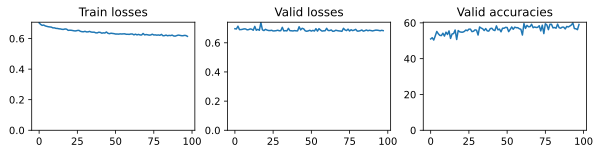

In [11]:
loss_fn = nn.NLLLoss()

D_in=1024
D_out=2
# When we create the model, its parameters are initialized. 
model=nn.Sequential(
                    nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
# Note this important to build a new optimizer 
# if we want to have the reference to parameters 
# of the new model ! 
train(model,98)

## 2. Un modèle plus complexe : une couche cachée

14923 1000
150 99
---------- Best : 76.600  at epoch  92  /  98


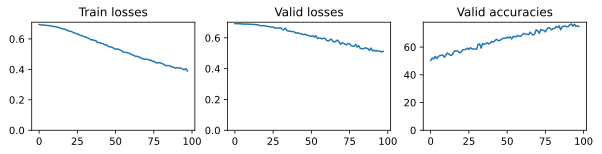

In [12]:
hidden_layer = 50
D_in = 1024 # image 32x32 aplatie
D_out= 2 # 2 sorties : classification binaire

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.0003)

train(model_best,98)

Les paramètres intéressants à optimiser sont : 
- La taille de la couche cachée.
- La *vitesse* d'apprentissage : *$l_{r}$* , conjointement au "batch_size" définit dans la fonction "train"

# 3. Convolution

Load the dataset : 

In [13]:
fp = gzip.open('CNN_dataset.pickle.gz','rb')
Xtrain,Xvalid,Ytrain,Yvalid = pickle.load(fp)

## a) create model

In [14]:
import torch.nn.functional as F

Penser au padding ! Meilleur estimation des bords ?

In [15]:
class Conv2d_classifier(nn.Module):   
    def __init__(self):
        super(Conv2d_classifier, self).__init__()
        self.conv1 = nn.Conv2d(1,8,5) # 1-grayscale ; 2-nbr sorties ; 3-kernel size
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*14*14,20) #conv1-pool-conv2-pool
        self.fc2 = nn.Linear(20,2) #2-classif binaire
        self.dropout = nn.Dropout(0.3) 

    # Defining the forward pass    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1,8*14*14) #-1- batch size #flatten it 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # softmax ? or is it in the loss
        return x

## b) online training

In [16]:
classif = Conv2d_classifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(classif.parameters(), lr=0.001)

14923 1000
150 99
---------- Best : 90.800  at epoch  64  /  70


(0.0, 92.625)

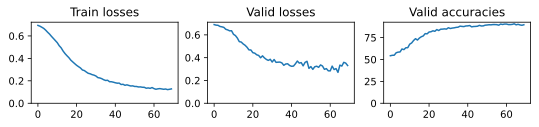

In [17]:
epochs = 70

Ntrain = Xtrain.shape[0]
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain)
batch_size = 150 # Beaucoup plus rapide que 1 ! 
nbatch = int(Ntrain/batch_size)
print(batch_size, nbatch)


train_losses,valid_losses, valid_accuracies=[],[],[]


for e in range(epochs):
    np.random.shuffle(idx)
    running_loss=0
    totaln = 0
    for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images !
        ids = idx[bi*batch_size:(bi+1)*batch_size]
        images = Xtrain[ids]
        labels = Ytrain[ids]
        totaln += labels.shape[0] # the number of samples
        optimizer.zero_grad()
        logprobs=classif(images)
        loss=loss_fn(logprobs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # training is over for one epoch
    # now compute interesting quantities
    accuracy=0
    valid_loss = 0        
    with th.no_grad(): # On est plus entrain d'apprendre, plus de gradient
        classif.eval()
        images = Xvalid
        labels = Yvalid
        logprobs=classif(images)
        valid_loss=loss_fn(logprobs,labels)
        top_p,top_class=logprobs.topk(1) #comment l'accuracy est elle calculé sur le set de valid ??
        accuracy=(top_class.T == labels).sum().float()
    classif.train()
    train_losses.append(running_loss/nbatch)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy.item()*100.0/Nvalid)
    '''
    print("Epoch: {}\t".format(e+1),
              "train Loss: {:.5f}.. ".format(train_losses[-1]),
              "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
              "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
    '''
print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
      , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )

plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies')
ax.set_ylim(bottom=0)
    

## Annexe 1. Dépendance en kT

### Upload test dataset, and compute accuracy :

De nombreux dataset de 1000 images à différents kT ont été générés et mis en annexes ("kT001" signifie kT=0.01 J).

L'intérêt du code suivant est d'**évaluer l'accuracy du modèle** : "classif" sur des datasets à **d'autres températures**. 

In [127]:
fp = gzip.open('CNN_dataset_kT100.pickle.gz','rb')
Xtest,Ytest = pickle.load(fp)

In [128]:
B=1000
images=Xtest[:B]
labels=Ytest[:B]
classif.eval()

logprobs=classif(images)
valid_loss=loss_fn(logprobs,labels)
top_p,top_class=logprobs.topk(1) #top_p = valeur de l'élément le plus grand ; top_class = sa classe (son indice !)
accuracy=(top_class.T == labels).sum().float()

acc=accuracy*100/B

print("The accuracy on this dataset is {} %".format(int(acc)))

The accuracy on this dataset is 50 %


On a rempli le tableau suivant en calculant l'accuracy à différente températures :

In [129]:
x=[0.0001,0.001,0.005,0.01,0.02,0.03,0.04,0.1,1,10,100]
y=[57,56,53,89,54,58,56,54,48,49,50]

Text(0, 0.5, 'accuracy (%)')

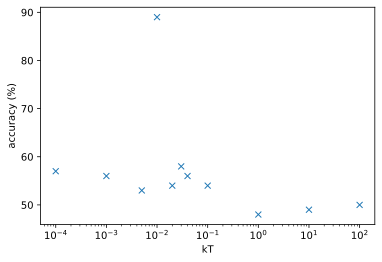

In [130]:
plt.plot(x,y,'x')
plt.xlabel('kT')
plt.xscale('log')
plt.ylabel('accuracy (%)')

## Annexe  2. Visualisation des convolutions 

Dans cette section, on **affiche** les opérations de convolutions appliquées par le réseau entrainé, à une image.

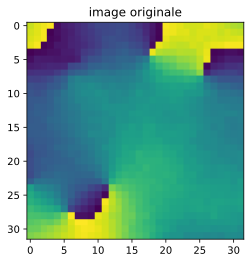

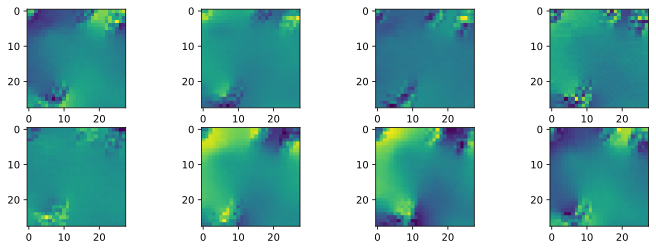

In [20]:
images = Xvalid

conv1 = nn.Conv2d(1,8,5)
conv=conv1(images)
conv_img=conv.detach().numpy()

N=600

plt.imshow(images[N,0])
plt.title('image originale')

# Ci dessous les 8 convolutions appliquées à l'image originale  : 
plt.figure(figsize = (12,4))
plt.subplot(2,4,1)
plt.imshow(conv_img[N,1])
plt.subplot(2,4,2)
plt.imshow(conv_img[N,2])
plt.subplot(2,4,3)
plt.imshow(conv_img[N,3])
plt.subplot(2,4,4)
plt.imshow(conv_img[N,4])
plt.subplot(2,4,5)
plt.imshow(conv_img[N,5])
plt.subplot(2,4,6)
plt.imshow(conv_img[N,6])
plt.subplot(2,4,7)
plt.imshow(conv_img[N,7])
plt.subplot(2,4,8)
plt.imshow(conv_img[N,0])